In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import warnings
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

In [2]:
data_path='../input/blood-cells/dataset2-master/dataset2-master/images'

In [3]:
TRAIN_PATH = data_path+'/'+'TRAIN'
TEST_PATH = data_path +'/'+'TEST'
VALID_PATH = data_path+'/'+'TEST_SIMPLE'

In [4]:
import cv2 
import matplotlib.pyplot as plt
from keras.preprocessing.image import *
from keras.applications import InceptionV3,VGG16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers, optimizers
from keras.models import *

Using TensorFlow backend.


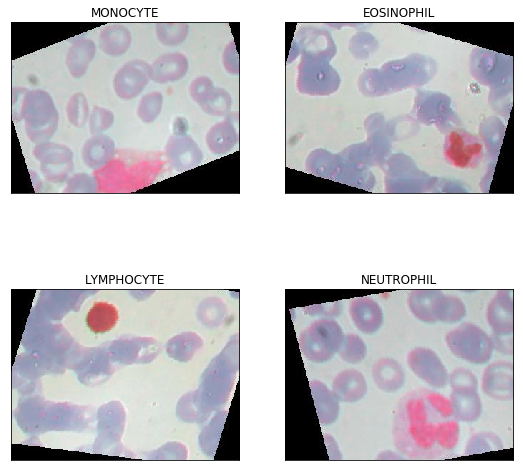

In [5]:
sample_data1_path = os.path.join(TRAIN_PATH+'/MONOCYTE','_11_3865.jpeg')
sample_data2_path = os.path.join(TRAIN_PATH+'/EOSINOPHIL','_41_6558.jpeg')
sample_data3_path = os.path.join(TRAIN_PATH+'/LYMPHOCYTE','_14_8262.jpeg')
sample_data4_path = os.path.join(TRAIN_PATH+'/NEUTROPHIL','_28_8416.jpeg')
sample_data1 = cv2.imread(sample_data1_path)
sample_data2 = cv2.imread(sample_data2_path)
sample_data3 = cv2.imread(sample_data3_path)
sample_data4 = cv2.imread(sample_data4_path)
img_shape =sample_data3.shape 
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(2, 2, 1,xticks=[],yticks=[],title='MONOCYTE')
ax1.imshow(sample_data1)
ax2 = fig.add_subplot(2, 2, 2,xticks=[],yticks=[],title='EOSINOPHIL')
ax2.imshow(sample_data2)
ax3 = fig.add_subplot(2, 2, 3,xticks=[],yticks=[],title='LYMPHOCYTE')
ax3.imshow(sample_data3)
ax4 = fig.add_subplot(2, 2, 4,xticks=[],yticks=[],title='NEUTROPHIL')
ax4.imshow(sample_data4)

In [6]:
train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

Already, The images are aumentated, So i didn't anything.

In [7]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(img_shape[0],img_shape[1]),
    batch_size=32,
    class_mode='categorical',
    seed=2019
    ,color_mode='rgb'  
)
valid_generator = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(img_shape[0],img_shape[1]),
    batch_size=32,
    class_mode='categorical',
    seed=2019
    ,color_mode='rgb'  
)
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(img_shape[0],img_shape[1]),
    batch_size=32,
    shuffle=False,
    class_mode='categorical',
    color_mode='rgb'
)

Found 9957 images belonging to 4 classes.
Found 71 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [8]:
def get_model():
    base_mdoel = InceptionV3(weights='imagenet',include_top=False,input_shape=img_shape)
    model= Sequential()
    model.add(base_mdoel)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='elu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, activation='softmax'))
    model.summary()
    optimizer = optimizers.Adam(lr=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
    return model

In [9]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [10]:
batch_size=32
model_path = '../model/'
if not os.path.exists(model_path):
    os.mkdir(model_path)
    
model_path = model_path + 'best_model.hdf5'
train_num = len(os.listdir(TRAIN_PATH+'/MONOCYTE')) +len(os.listdir(TRAIN_PATH+'/EOSINOPHIL')) +len(os.listdir(TRAIN_PATH+'/LYMPHOCYTE')) +len(os.listdir(TRAIN_PATH+'/NEUTROPHIL'))
test_num = len(os.listdir(VALID_PATH+'/MONOCYTE')) +len(os.listdir(TEST_PATH+'/EOSINOPHIL')) +len(os.listdir(TEST_PATH+'/LYMPHOCYTE')) +len(os.listdir(TEST_PATH+'/NEUTROPHIL'))
valid_num = len(os.listdir(VALID_PATH+'/MONOCYTE')) +len(os.listdir(VALID_PATH+'/EOSINOPHIL')) +len(os.listdir(VALID_PATH+'/LYMPHOCYTE')) +len(os.listdir(VALID_PATH+'/NEUTROPHIL'))

In [11]:
callbacks1 = [EarlyStopping(monitor='val_loss',patience=2,mode='min',verbose=1),
            ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 1, min_lr=0.00001, verbose=1, mode='min'),
            ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),]

In [12]:
my_inception_model =get_model()

87916544/87910968 [==============================] - 7s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (De

In [14]:
history = my_inception_model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(train_num, batch_size),
    epochs=100,
    validation_data=test_generator,
    validation_steps=get_steps(test_num, batch_size),
    verbose=1,
    callbacks = callbacks1
)

Epoch 1/100
312/312 [==============================] - 90s 288ms/step - loss: 0.1562 - acc: 0.9535 - val_loss: 10.6944 - val_acc: 0.3284

Epoch 00001: val_loss did not improve from 2.04468
Epoch 2/100
312/312 [==============================] - 88s 283ms/step - loss: 0.0729 - acc: 0.9748 - val_loss: 0.7706 - val_acc: 0.8691

Epoch 00002: val_loss improved from 2.04468 to 0.77057, saving model to ../model/best_model.hdf5
Epoch 3/100
312/312 [==============================] - 88s 282ms/step - loss: 0.0271 - acc: 0.9922 - val_loss: 1.0911 - val_acc: 0.7951

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00003: val_loss did not improve from 0.77057
Epoch 4/100
312/312 [==============================] - 88s 283ms/step - loss: 0.0264 - acc: 0.9952 - val_loss: 3.4977 - val_acc: 0.5710

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00004: val_loss did not improve from 0.77057
Epoch 00004: early stopping


history = my_inception_model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(train_num, batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(valid_num, batch_size),
    verbose=1,
    callbacks = callbacks
)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Traing loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Trainging and validation loss')
plt.legend()
plt.show()


In [16]:
test_generator.reset()
my_inception_model.load_weights(model_path)
scores = my_inception_model.evaluate_generator(test_generator,steps=get_steps(test_num,batch_size),verbose=1)

59/59 [==============================] - 6s 102ms/step


In [18]:
print("loss",scores[0],"acc:",scores[1])

loss 0.7752026362256818 acc: 0.8686440677966102
